In [1]:
import random, os
import numpy as np
import pandas as pd
from functools import reduce
import seaborn as sns
from sklearn import datasets
from sklearn.metrics.scorer import make_scorer
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_log_error, mean_squared_error
from tqdm import tqdm

In [2]:
from fastai.imports import *
from fastai.structured import *

In [3]:
df_raw = pd.read_csv(f'data/Train.csv', low_memory=False, 
                     parse_dates=["saledate"])

In [4]:
add_datepart(df_raw, 'saledate')
train_cats(df_raw)

In [5]:
os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/bulldozers-raw')

In [6]:
df_raw = pd.read_feather('tmp/bulldozers-raw')
df_raw.SalePrice = np.log(df_raw.SalePrice)

In [7]:
df, y, nas = proc_df(df_raw, 'SalePrice')

In [8]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    df, y, test_size=0.2, random_state=0)

In [27]:
#RandomForestClassifier(
#     n_estimators='warn',
#     criterion='gini',
#     max_depth=None,
#     min_samples_split=2,
#     min_samples_leaf=1,
#     min_weight_fraction_leaf=0.0,
#     max_features='auto',
#     max_leaf_nodes=None,
#     min_impurity_decrease=0.0,
#     min_impurity_split=None,
#     bootstrap=True,
#     oob_score=False,
#     n_jobs=None,
#     random_state=None,
#     verbose=0,
#     warm_start=False,
#     class_weight=None,

In [9]:
params_default = {
         'n_estimators'     : list(range(10,100,50)),
         'max_depth'        : [None, 3, 5, 10],
         'min_samples_split': [2, 4, 6, 8],
         'max_features'     : [0.2, 0.5, 0.8, 1]}

In [10]:
def get_random(params: dict()):
    result = dict()
    for key in params.keys(): result[key] = random.choice(params[key])
    return result

get_random(params_default)

{'n_estimators': 60,
 'max_depth': 5,
 'min_samples_split': 2,
 'max_features': 0.8}

In [11]:
full_search = reduce(lambda x, y: x*y, [len(x) for x, y in params_default.items()])

In [12]:
full_search

22032

In [13]:
def evaluate(**kwargs):
    clf = RandomForestRegressor(**kwargs)
    clf.fit(X_train, y_train)
    return clf.score(X_test, y_test)

In [14]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

clf = RandomForestRegressor(n_jobs=8)
clf.fit(X_train, y_train)
print(rmse(clf.predict(X_test), y_test))

/Users/oleksandrsavsunenko/anaconda3/envs/data/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.217183349554194


In [15]:
best_params = dict()
best_accuracy = float('Inf')
acc_dynamics = pd.DataFrame(columns=['step','best_accuracy'])
n_steps = 50
for i in tqdm(range(0, n_steps)):
    current_params = get_random(params_default)
    current_acc = evaluate(**current_params)
    if current_acc<best_accuracy:
        best_accuracy = current_acc 
        best_params = current_params
    acc_dynamics=acc_dynamics.append({'step':i,'best_accuracy':best_accuracy}, ignore_index=True)

 32%|███▏      | 16/50 [10:53<13:34, 23.95s/it]

KeyboardInterrupt: 

In [16]:
best_accuracy

0.22117224908067856

In [17]:
best_params

{'n_estimators': 60, 'max_depth': 3, 'min_samples_split': 4, 'max_features': 1}

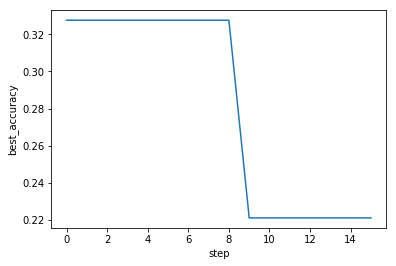

In [18]:
sns.lineplot(x=acc_dynamics['step'], y=acc_dynamics['best_accuracy'])

In [19]:
acc_dynamics['best_accuracy'].values.argmin()

9

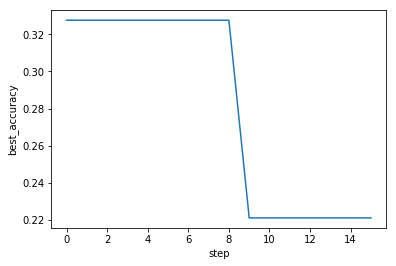

In [20]:
sns.lineplot(x=acc_dynamics['step'][0:400], y=acc_dynamics['best_accuracy'][0:400])

In [21]:
acc = []
for cv in tqdm(range(0,100)):
    best_params = dict()
    best_accuracy = float('Inf')
    acc_dynamics = pd.DataFrame(columns=['step','best_accuracy'])
    n_steps = 50
    for i in range(0, n_steps):
        current_params = get_random(params_default)
        current_acc = evaluate(**current_params)
        if current_acc<best_accuracy:
            best_accuracy = current_acc 
            best_params = current_params
        acc_dynamics=acc_dynamics.append({'step':i,'best_accuracy':best_accuracy}, ignore_index=True)
    acc.append(best_accuracy)


  0%|          | 0/100 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
np.mean(acc)

In [ ]:
np.median(acc)